## 2.8 Pythonによる分析の準備

In [1]:
# ライブラリ
import numpy as np
import pandas as pd
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.precision", 3)

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = "Meiryo"
import seaborn as sns
sns.set()

# sns.set()で日本語化がリセットされるぽいのでここでjapanize_matplotlibを実行
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()

# warningsを表示しない
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 4.1 MB 7.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=2def1702d02ce1aca656cb122b05937ef34b9548ad3444faa80b2670dec89259
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
# 予測の同時分布
joint_forecast_state = pd.DataFrame({
    "予測－問題なし": [0.35, 0.1], 
    "予測－問題あり": [0.05, 0.5]
})
joint_forecast_state.index = ["問題なし", "問題あり"]
joint_forecast_state

,予測－問題なし,予測－問題あり
問題なし,0.35,0.05
問題あり,0.10,0.50


In [3]:
# 予測の周辺分布
marginal_forecast = joint_forecast_state.sum(axis = 0)
marginal_forecast

予測－問題なし    0.45
予測－問題あり    0.55
dtype: float64

In [4]:
# 自然の状態の周辺分布
marginal_state = joint_forecast_state.sum(axis = 1)
marginal_state

問題なし    0.4
問題あり    0.6
dtype: float64

In [5]:
# 予測が得られた後の条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis = 1)
conditional_forecast

,予測－問題なし,予測－問題あり
問題なし,0.778,0.091
問題あり,0.222,0.909


## 2.9 Pythonによるコスト/ロスモデルの結果の確認

In [6]:
# 決定方式（常に対策なし，常に対策あり，予測に忠実に従う）別にESVを計算

# コスト/ロス比は0～1
cl_ratio_array = np.arange(0.01, 1, 0.01)

# スケーリングされた期待利得
esv_naive_1 = -1 * np.repeat(marginal_state["問題あり"], len(cl_ratio_array)) # 常に対策なし
esv_naive_2 = -1 * cl_ratio_array # 常に対策あり
esv_f = -1 * joint_forecast_state.loc["問題あり", "予測－問題なし"] - marginal_forecast["予測－問題あり"] * cl_ratio_array # 予測に忠実に従う

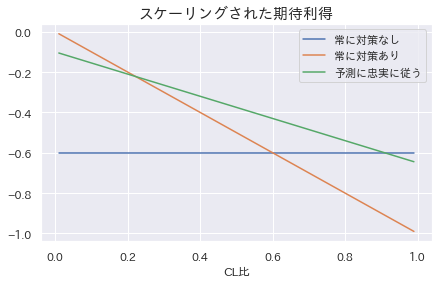

In [7]:
# ESVを可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(cl_ratio_array, esv_naive_1, label = "常に対策なし")
ax.plot(cl_ratio_array, esv_naive_2, label = "常に対策あり")
ax.plot(cl_ratio_array, esv_f, label = "予測に忠実に従う")
ax.set_title("スケーリングされた期待利得", fontsize = 15)
ax.set_xlabel("CL比")
ax.legend(loc = "upper right")

In [8]:
# 予測が価値を生み出す範囲
lower = conditional_forecast.loc["問題あり", "予測－問題なし"]
upper = conditional_forecast.loc["問題あり", "予測－問題あり"]
print(f"予測が価値を生み出すCL比の範囲：{lower:.3g}～{upper:.3g}")

予測が価値を生み出すCL比の範囲：0.222～0.909


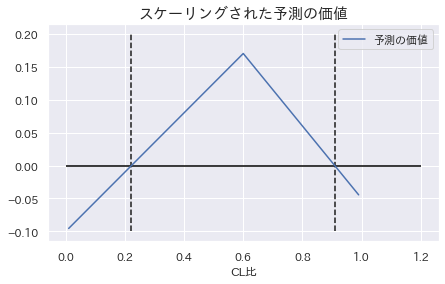

In [9]:
# コスト/ロス比別の予測の価値

# 無技術最良予測に従うときの期待利得
esv_naive = np.maximum(esv_naive_1, esv_naive_2)

# 予測の価値
value_f = esv_f - esv_naive

# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(cl_ratio_array, value_f, label = "予測の価値")
ax.vlines(x = lower, ymin = -0.1, ymax = 0.20, linestyle = "--")
ax.vlines(x = upper, ymin = -0.1, ymax = 0.20, linestyle = "--")
ax.hlines(y = 0, xmin = 0, xmax = 1.2, color = "black")
ax.set_title("スケーリングされた予測の価値", fontsize = 15)
ax.set_xlabel("CL比")
ax.legend(loc = "best")

In [10]:
# スケーリングされた予測の価値を計算する関数
def forecast_value(cl_ratio, joint_prob):

  # 周辺分布
  marginal_forecast = joint_prob.sum(axis = 0)
  marginal_state = joint_prob.sum(axis = 1)

  # ESVの計算
  esv_naive_1 = -1 * marginal_state[1] # 常に対策なし
  esv_naive_2 = -1 * cl_ratio # 常に対策あり
  esv_f = -1 * joint_prob.iloc[1, 0] - marginal_forecast[1] * cl_ratio # 予測に忠実に従う

  # 予測の価値を計算
  esv_naive = np.maximum(esv_naive_1, esv_naive_2) # 無技術最良予測
  value_f = esv_f - esv_naive # 予測の価値

  return value_f

In [11]:
# 関数を使うと，CL比を変化させたときの予測の価値を簡単に計算可能
value_f_func = np.apply_along_axis(func1d = forecast_value, axis = 0, arr = cl_ratio_array, joint_prob = joint_forecast_state)
value_f_func

array([-0.0955, -0.091 , -0.0865, -0.082 , -0.0775, -0.073 , -0.0685,
       -0.064 , -0.0595, -0.055 , -0.0505, -0.046 , -0.0415, -0.037 ,
       -0.0325, -0.028 , -0.0235, -0.019 , -0.0145, -0.01  , -0.0055,
       -0.001 ,  0.0035,  0.008 ,  0.0125,  0.017 ,  0.0215,  0.026 ,
        0.0305,  0.035 ,  0.0395,  0.044 ,  0.0485,  0.053 ,  0.0575,
        0.062 ,  0.0665,  0.071 ,  0.0755,  0.08  ,  0.0845,  0.089 ,
        0.0935,  0.098 ,  0.1025,  0.107 ,  0.1115,  0.116 ,  0.1205,
        0.125 ,  0.1295,  0.134 ,  0.1385,  0.143 ,  0.1475,  0.152 ,
        0.1565,  0.161 ,  0.1655,  0.17  ,  0.1645,  0.159 ,  0.1535,
        0.148 ,  0.1425,  0.137 ,  0.1315,  0.126 ,  0.1205,  0.115 ,
        0.1095,  0.104 ,  0.0985,  0.093 ,  0.0875,  0.082 ,  0.0765,
        0.071 ,  0.0655,  0.06  ,  0.0545,  0.049 ,  0.0435,  0.038 ,
        0.0325,  0.027 ,  0.0215,  0.016 ,  0.0105,  0.005 , -0.0005,
       -0.006 , -0.0115, -0.017 , -0.0225, -0.028 , -0.0335, -0.039 ,
       -0.0445])

In [12]:
# CL比=0.4の需要予測ユーザーの予測の価値
value_04 = forecast_value(0.4, joint_forecast_state)
print(f"CL比が0.4のユーザーの予測の価値：{value_04:.3g}")
print(f"CL比が0.4，損失Lが1000万のユーザーの予測の価値：{value_04 * 1000:.3g}万")

CL比が0.4のユーザーの予測の価値：0.08
CL比が0.4，損失Lが1000万のユーザーの予測の価値：80万


## 2.10 予測の的中率と予測の価値の関係

In [13]:
# 予測が価値を生み出すために必要な的中率を求める関数
def required_accuracy(cl_ratio, p_theta):
  ret = np.where(cl_ratio >= p_theta, 
                 1 - 2 * p_theta * (1 - cl_ratio), 
                 1 - 2 * cl_ratio * (1 - p_theta))
  return ret

In [14]:
# 自然の状態＝問題ありの確率が0.8のときに，CL比が0.2の意思決定者の予測が価値を生み出すために必要な的中率
required_accuracy(0.2, 0.8)

array(0.92)

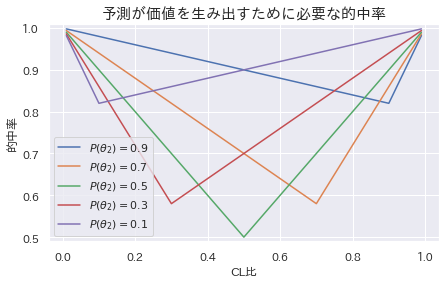

In [15]:
# 可視化

# CL比
cl_ratio_array = np.arange(0.01, 1, 0.01)

# 予測が価値を生み出すために必要な的中率
req_acc09 = np.apply_along_axis(required_accuracy, axis = 0, arr = cl_ratio_array, p_theta = 0.9)
req_acc07 = np.apply_along_axis(required_accuracy, axis = 0, arr = cl_ratio_array, p_theta = 0.7)
req_acc05 = np.apply_along_axis(required_accuracy, axis = 0, arr = cl_ratio_array, p_theta = 0.5)
req_acc03 = np.apply_along_axis(required_accuracy, axis = 0, arr = cl_ratio_array, p_theta = 0.3)
req_acc01 = np.apply_along_axis(required_accuracy, axis = 0, arr = cl_ratio_array, p_theta = 0.1)

# 描画
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(cl_ratio_array, req_acc09, label = r"$P(\theta_2)=0.9$")
ax.plot(cl_ratio_array, req_acc07, label = r"$P(\theta_2)=0.7$")
ax.plot(cl_ratio_array, req_acc05, label = r"$P(\theta_2)=0.5$")
ax.plot(cl_ratio_array, req_acc03, label = r"$P(\theta_2)=0.3$")
ax.plot(cl_ratio_array, req_acc01, label = r"$P(\theta_2)=0.1$")
ax.set_title("予測が価値を生み出すために必要な的中率", fontsize = 15)
ax.set_ylim(0.49, 1.01)
ax.set_xlabel("CL比")
ax.set_ylabel("的中率")
ax.legend(loc = "best")

## 2.11 個別ユーザーのための予測の最適化

In [16]:
# 的中率を求める関数
def accuracy(joint_prob):
  return joint_prob.iloc[0, 0] + joint_prob.iloc[1, 1]

In [17]:
# いろいろな同時分布を持つ予測を用意

# バイアスのない予測
zero_bias = pd.DataFrame({
    "予測－問題なし": [0.4, 0.1], 
    "予測－問題あり": [0.1, 0.4]
})
zero_bias.index = ["問題なし", "問題あり"]
print(f"■バイアスのない予測（的中率：{accuracy(zero_bias)}）")
print(zero_bias)

# 見逃し（false negative）を減らした予測
decrease_fn = pd.DataFrame({
    "予測－問題なし": [0.3, 0.05], 
    "予測－問題あり": [0.2, 0.45]
})
decrease_fn.index = ["問題なし", "問題あり"]
print(f"\n■見逃しを減らした予測（的中率：{accuracy(decrease_fn)}）")
print(decrease_fn)

# 空振り（false positive）を減らした予測
decrease_fp = pd.DataFrame({
    "予測－問題なし": [0.45, 0.2], 
    "予測－問題あり": [0.05, 0.3]
})
decrease_fp.index = ["問題なし", "問題あり"]
print(f"\n■空振りを減らした予測（的中率：{accuracy(decrease_fp)}）")
print(decrease_fp)

■バイアスのない予測（的中率：0.8）
          予測－問題なし  予測－問題あり
問題なし             0.4             0.1
問題あり             0.1             0.4

■見逃しを減らした予測（的中率：0.75）
          予測－問題なし  予測－問題あり
問題なし            0.30            0.20
問題あり            0.05            0.45

■空振りを減らした予測（的中率：0.75）
          予測－問題なし  予測－問題あり
問題なし            0.45            0.05
問題あり            0.20            0.30


In [18]:
# CL比=0.5の場合
print(f"バイアスなし予測の価値：{forecast_value(0.5, zero_bias):.3g}")
print(f"見逃し減少予測の価値：{forecast_value(0.5, decrease_fn):.3g}")
print(f"空振り減少予測の価値：{forecast_value(0.5, decrease_fp):.3g}")

バイアスなし予測の価値：0.15
見逃し減少予測の価値：0.125
空振り減少予測の価値：0.125


In [19]:
# CL比=0.3の場合
print(f"バイアスなし予測の価値：{forecast_value(0.3, zero_bias):.3g}")
print(f"見逃し減少予測の価値：{forecast_value(0.3, decrease_fn):.3g}")
print(f"空振り減少予測の価値：{forecast_value(0.3, decrease_fp):.3g}")

バイアスなし予測の価値：0.05
見逃し減少予測の価値：0.055
空振り減少予測の価値：-0.005


In [20]:
# CL比=0.7の場合
print(f"バイアスなし予測の価値：{forecast_value(0.7, zero_bias):.3g}")
print(f"見逃し減少予測の価値：{forecast_value(0.7, decrease_fn):.3g}")
print(f"空振り減少予測の価値：{forecast_value(0.7, decrease_fp):.3g}")

バイアスなし予測の価値：0.05
見逃し減少予測の価値：-0.005
空振り減少予測の価値：0.055


## 2.12 完全的中予測の価値

In [21]:
# 完全的中予測の価値を計算する関数
def perfect_forecast_value(cl_ratio, marginal_state):

  # ESV計算
  esv_naive_1 = -1 * marginal_state[1] # 常に対策なし
  esv_naive_2 = -1 * cl_ratio # 常に対策なし
  esv_perfect = -1 * cl_ratio * marginal_state[1] # 完全的中予測に従う

  # 予測の価値の計算
  esv_naive = np.maximum(esv_naive_1, esv_naive_2)
  value_p = esv_perfect - esv_naive

  return value_p

In [24]:
# P(θ2)=0.6のときの，CL比=0.4のユーザーの完全的中予測の価値
value_p = perfect_forecast_value(0.4, marginal_state)
print(f"CL比が0.4のユーザーの完全的中予測の価値：{value_p:.3g}")

CL比が0.4のユーザーの完全的中予測の価値：0.16


問題なし    0.4
問題あり    0.6
dtype: float64

## 2.13 予測の有効性

In [26]:
# 予測の価値と完全的中予測の価値
value_p = perfect_forecast_value(0.4, marginal_state)
value_f = forecast_value(0.4, joint_forecast_state)

# 予測の有効性
efficiency = value_f / value_p
print(f"予測の有効性：{efficiency:.3g}")

予測の有効性：0.5


### CL比別予測の価値と有効性

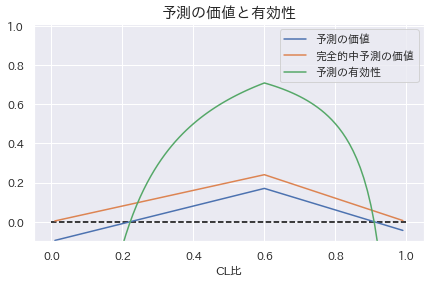

In [35]:
# CL比
cl_ratio_array = np.arange(0.01, 1, 0.01)

# 予測の価値
value_f = np.apply_along_axis(func1d = forecast_value, axis = 0, arr = cl_ratio_array, joint_prob = joint_forecast_state)

# 完全的中予測の価値
value_p = np.apply_along_axis(func1d = perfect_forecast_value, axis = 0, arr = cl_ratio_array, marginal_state = marginal_state)

# 予測の有効性
efficiency = value_f / value_p

# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(cl_ratio_array, value_f, label = "予測の価値")
ax.plot(cl_ratio_array, value_p, label = "完全的中予測の価値")
ax.plot(cl_ratio_array, efficiency, label = "予測の有効性")
ax.hlines(y = 0, xmin = 0, xmax = 1.0, color = "black", linestyle = "--")
ax.set_title("予測の価値と有効性", fontsize = 15)
ax.set_ylim(-0.1, 1.01)
ax.set_xlabel("CL比")
ax.legend(loc = "best")

## 2.15 Peirceのスキルスコア

In [37]:
# 数値的に求める
print(f"Peirceのスキルスコア：{max(efficiency):.3g}")

Peirceのスキルスコア：0.708


In [40]:
# 自然の状態の条件付き分布から求める
conditional_state = joint_forecast_state.div(marginal_state, axis = 0)
peirce = conditional_state.loc["問題あり", "予測－問題あり"] - conditional_state.loc["問題なし", "予測－問題あり"]
print(f"Peirceのスキルスコア：{peirce:.3g}")

Peirceのスキルスコア：0.708
